<a name = 'content'></a>

# Лабораторная работа №3

### Учебная группа: М8О-409Б-18
## Рябыкин Алексей

----
## Оглавление:

-----

### [1. Задание и вариант](#step1)

### [2. Подготовительная часть](#step2)

### [3. Аналитическое решение](#step3)

### [4. Метод Либмана](#step4)

* [Теория](#step4.1)

* [Программная реализация](#step4.2)

* [Исследовательская часть](#step4.3)

### [5. Метод верхних релаксаций](#step5)

* [Теория](#step5.1)

* [Программная реализация](#step5.2)

* [Исследовательская часть](#step5.3)

### [6. Метод Зейделя](#step6)

* [Теория](#step6.1)

* [Программная реализация](#step6.2)

* [Исследовательская часть](#step6.3)


<a name = 'step1'></a>

## Задание

[К оглавлению](#content)

Решить краевую задачу для дифференциального уравнения эллиптического типа. Аппроксимацию уравнения произвести с использованием центрально-разностной схемы. Для решения дискретного аналога применить следующие методы: метод простых итераций (метод Либмана), метод Зейделя, метод простых итераций с верхней релаксацией. Вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $U(x,y)$. Исследовать зависимость погрешености от сеточных параметров $h_x, h_y$

### Вариант 7

Задача Дирихле:
$$\begin{aligned} 
&\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} = -2u \hspace{1cm}  \\ \\
&u(0,y) = \cos y\\
&u\left(\frac{\pi}{2}, y\right) = 0\\
&u(x,0) = \cos x\\
&u\left(x,\frac{\pi}{2}\right) = 0\end{aligned}$$

Аналитическое решение: $U(x,y) = \cos x\cos y$

<a name = 'step2'></a>
## Подготовительная часть

[К оглавлению](#content)

In [1]:
import math
import numpy as np
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import time
import plotly.io as pio
pio.renderers.default = 'notebook'
import copy
co = 0

In [56]:
def analytic(x,y):
    return math.cos(x)*math.cos(y)
def f_1(x,y):
    return math.cos(y)
def f_2(x,y = None):
    return 0
def f_3(x,y = None):
    return math.cos(x)
def f_4(x,y = None):
    return 0
        
def MSE(x,y,u):
    error = 0
    for x_ in range(len(x)):
        for y_ in range(len(y)):
            error += (u[x_][y_] - analytic(x[x_],y[y_]))**2
    return (error/(len(x)*len(y)))/(len(x)*len(y))
            
def MAE(x,t,u):
    error = 0
    for x_ in range(len(x)):
        for y_ in range(len(y)):
            error += abs(u[x_][y_] - analytic(x[x_], y[y_]))
    return error/(len(x) * len(y))
    
def normm(x,t,u):
    errors = []
    for i in range(len(u)):
        maximum = 0
        for j in range(len(x)):
            tmp = abs(u[i][j] - analytic(x[j], t[i]))
            if maximum < tmp:
                maximum = tmp
        errors.append(maximum)
    return errors

def norm(current, prev, len_x, len_y):
    max_ = 0
    for i in range(len_x):
        for j in range(len_y):
            if (abs(current[i][j] - prev[i][j]) > max_):
                max_ = abs(current[i][j] - prev[i][j])
    return max_
def norm_error(x,t,u):
    ans = 0.0
    for i in range(len(u)):
        for j in range(len(u[i])):
            ans += (u[i][j] - analytic(x[i][j], t[i][j]))**2
    return ans/(len(u[0]) * len(u))**2
    
def construct_3d_plot(method, method_name):
    approx_e, X_e, T_e, it = method()
    z_plot = []
    for j in range(0, len(X_e), 1):
        tmp = []
        for i in range(0, len(X_e[j]), 1):
            tmp.append(analytic(X_e[j][i], T_e[j][i]))
        z_plot.append(tmp)
    line_marker = dict(color='#0066FF', width=2)
    lines = []
    lines.append(go.Scatter3d(x=X_e[0], y=T_e[0], z=approx_e[0], mode='lines', line=line_marker, name = method_name + "method", legendgroup=1))
    for i, j, k in zip(X_e[1:], T_e[1:], approx_e[1:]):
        lines.append(go.Scatter3d(x=i, y=j, z=k, mode='lines', line=line_marker, showlegend=False))
    line_marker = dict(color='#ff0000', width=2)
    fig_new = go.Figure(data = lines)
    fig_new.update_scenes(xaxis_title=dict(text = 'x'), yaxis_title = dict(text = 'y'), zaxis_title = dict(text = "U(x,y)"))
    fig_new.add_trace(go.Scatter3d(x=X_e[0], y=T_e[0], z=z_plot[0], mode='lines', line=line_marker, name = 'Analytic', legendgroup = 2))
    for i, j, k in zip(X_e[1:], T_e[1:], z_plot[1:]):
        fig_new.add_trace(go.Scatter3d(x=i, y=j, z=k, mode='lines', line=line_marker, showlegend=False))
    fig_new.update_layout(title = 'Comparison 3D',
                          template = 'plotly_dark')
    fig_new.show()

    print("Total error = ", norm_error(X_e, T_e, approx_e))
    

  
    
def d3Analytic(xr = math.pi/2, yr = math.pi/2, len_x = 100, len_y = 100):
    hx = xr/len_x
    hy = yr/len_y
    x = [0 + hx * i for i in range(len_x)]
    y = [0 + hy * i for i in range(len_y)]
    X = [x for _ in range(len_x)]
    Y = [[y[i] for _ in x] for i in range(len_y)]
    z_plot = []
    for j in range(len(X)):
        tmp = []
        for i in range(len(X[j])):
            tmp.append(analytic(X[j][i], Y[j][i]))
        z_plot.append(tmp)
    fig = plt.figure(figsize=(20, 10))
    for i in range(50):
        plt.plot(y, z_plot[i])
    plt.xlabel('y')
    plt.ylabel(r'$U(x,y) = \cos x \cos y$')
    plt.title('Analytical Solution (different x)')
    plt.show()
#     line_marker = dict(color='#0066FF', width=2)
#     lines = []
#     fig_tmp = go.Figure()
#     for i in range(50):
#         fig_tmp.add_trace(go.Scatter(x = y, y = z_plot[i], name = "x = " + str(round(x[i],2))))
#     fig_tmp.update_layout(title = 'Analytical Solution (different x)',
#                          xaxis_title = 'y',
#                          yaxis_title = r'$U(x,y) = \cos x \cos y$',
#                          template = 'plotly_dark')
#     fig_tmp.show()
#     lines.append(go.Scatter3d(x=X[0], y=Y[0], z=z_plot[0], mode='lines', line=line_marker, name = "Analytic", legendgroup=1))
#     for i, j, k in zip(X[1:], Y[1:], z_plot[1:]):
#         lines.append(go.Scatter3d(x=i, y=j, z=k, mode='lines', line=line_marker, showlegend=False))
#     line_marker = dict(color='#ff0000', width=2)
#     fig_new = go.Figure(data = lines)
#     fig_new.update_scenes(xaxis_title=dict(text = 'x'), yaxis_title = dict(text = 'y'), zaxis_title = dict(text = "U(x,y)"))
#     fig_new.update_layout(title = "Analytical solution",
#                           template = 'plotly_dark')
#     fig_new.show()

<a name = 'step3'></a>

## Аналитическое решение
[К оглавлению](#content)

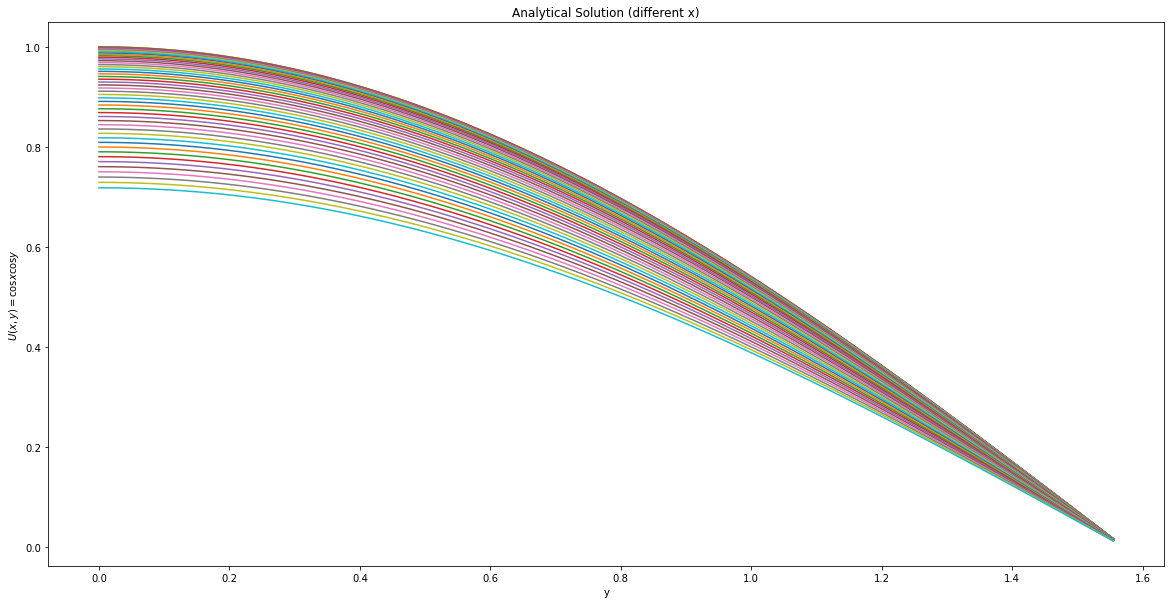

In [57]:
d3Analytic()

<a name = 'step4'></a>

## Метод Либмана

[К оглавлению](#content)

<a name = 'step4.1'></a>

### Теория

Рассматриваем краевую задачу в прямоугольнике $x \in [0,l_1],\ y \in [0,l_2]$, на который накладывается сетка:

$$\omega_{h_1,h_2} = \{x_i = ih_1,\ i = \overline{0,N_1}; \hspace{0.2cm} y_j = jh_2,\ j = \overline{0,N_2}\}$$

Внутренние узлы аппроксимируем с помощью отношения конечных разностей:

$$\begin{aligned} &\frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{h_1^2} + \frac{u_{i,j+1} -2u_{i,j} + u_{i,j-1}}{h_2^2} + O(h_1^2 + h_2^2) = f(x_i, y_j)\\
&i = \overline{1,N_1-1} \hspace{10cm} j = \overline{1,N_2-1} \end{aligned}$$

СЛАУ из этой системы -- пяти-диагональные матрицы с ленточной структурой. 

Метод Либмана -- один из методов решения подобных матриц:

Метод Либмана численного решения задачи Дирихле ($k$-номер итерации):

$$\begin{aligned} &u_{i,j}^{(k+1)} = \frac{1}{4}\left[ u_{i+1,j}^{(k} + u_{i-1,j}^{(k)} + u_{i,j+1}^{(k)} - h^2\cdot f_{i,j} \right], \hspace{0.5cm} f_{i,j} = f(x_i, y_j)\\
&i = \overline{1,N_1-1} \hspace{10cm} j = \overline{1,N_2-1} \end{aligned}$$

На нулевой итерации определим $u_{i,j}^{(0)}$ с помощью линейной интерполяции граничных значений.

Процесс Либмана прекращается, когда 
$$||u^{(k+1)} - u^{(k)}|| \leq \varepsilon \hspace{0.5cm} ||u^{(k)}|| = \underset{i,j}{\max}\left| u_{i,j}^{(k)} \right|$$

<a name = 'step4.2'></a>
### Реализация

In [58]:
def liebman(xr = math.pi/2, yr = math.pi/2, len_x = 75, len_y = 75, varepsilon = 1e-5):
    hx = xr/len_x
    hy = yr/len_y
    x = np.arange(0, xr + hx/2, hx)
    y = np.arange(0, yr + hy/2, hy)
    X = [x for _ in range(len(x))]
    Y = [[y[i] for _ in x] for i in range(len(y))]
    prev_t = np.zeros([len(x), len(y)])
    cur_t = np.zeros([len(x), len(y)])
    for j in range(len(y)):
        coeff = (f_2(None, y[j]) - f_1(None, y[j])) / (len(x) - 1)
        addition = f_1(None, y[j])
        for i in range(len(x)):
            cur_t[i][j] = coeff * i + addition
    count = 0
    while (True):
        count += 1
        prev_t = copy.deepcopy(cur_t)
        for i in range(1,len(x)-1):
            cur_t[i][0] = f_3(x[i])
            prev_t[i][0] = f_3(x[i])
            for j in range(1, len(y)-1):
                left = 2*(1/(hx**2) + 1/(hy**2)-1)
                right_fst = 1/(hx**2)
                right_scd = 1/(hy**2)
                cur_t[i][j] = right_fst* (prev_t[i+1][j] + prev_t[i-1][j]) + \
                                right_scd* (prev_t[i][j+1] + prev_t[i][j-1])
                cur_t[i][j] /= (left)
                #cur_t[i][j] = (-2*hx**2*hy**2*prev_t[i][j] + hy**2*(prev_t[i+1][j] + prev_t[i-1][j]) + hx**2*(prev_t[i][j+1] + prev_t[i][j-1]))/(2*(hx**2 + hy**2))
            cur_t[i][-1] = f_4(x[i])
            prev_t[i][-1] = f_4(x[i])
        norm_ = norm(cur_t, prev_t, len(x), len(y))
        if norm_ <= varepsilon:
            break
    return cur_t, X, Y, count

<a name = 'step4.3'></a>
### Исследования

In [59]:
xr = math.pi/2
yr = math.pi/2
len_x = 75
len_y = 75
x_step = xr/len_x
y_step = yr/len_y
varepsilon = 1e-5
x = np.arange(0, xr + x_step/2, x_step)
y = np.arange(0, yr + y_step/2, y_step)
# x = [0 + x_step*i for i in range(len_x)]
# y = [0 + y_step*i for i in range(len_y)]


In [60]:
import time 
start = time.time()
ans = liebman(xr,yr,len_x, len_y, varepsilon)
u_lib = ans[0]
time_liebman = time.time() - start
count_liebman = ans[-1]

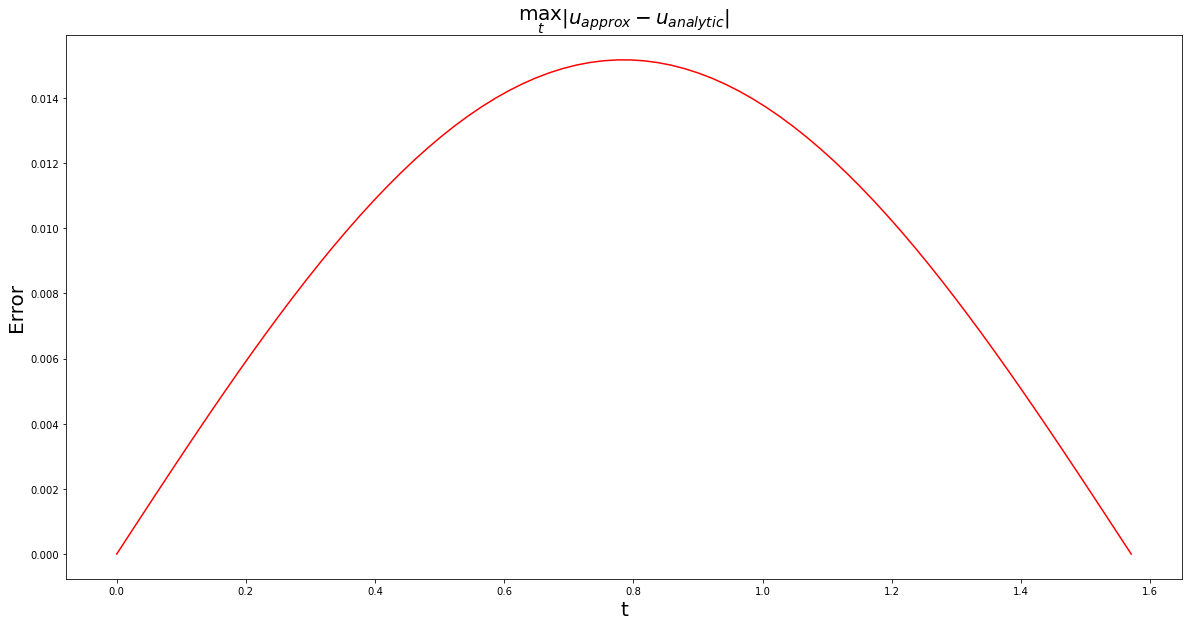

In [61]:
er = normm(x,y,u_lib)
fig = plt.figure(figsize=(20, 10))
plt.plot(x, er, color = 'red')
plt.xlabel('y', fontsize = 20)
plt.ylabel('Error', fontsize = 20)
plt.title(r'$\max_{t} \left|u_{approx} - u_{analytic}\right|$', fontsize = 20)
plt.show()
#plotly
# fig_check_tmp = go.Figure()
# fig_check_tmp.add_trace(go.Scatter(x = y, y = er))
# fig_check_tmp.update_layout(title = "Error (fix x)",
#                             xaxis_title = "y",
#                             yaxis_title = r'$\max |u - analytic|$', 
#                             template='plotly_dark')
# fig_check_tmp.show()
# fig_check_tmp = go.Figure()
# fig_check_tmp.add_trace(go.Scatter(x = x, y = er))
# fig_check_tmp.update_layout(title = "Error (fix y)",
#                             xaxis_title = "x",
#                             yaxis_title = r'$\max |u - analytic|$', 
#                             template='plotly_dark')
# fig_check_tmp.show()
#save_plot(fig_check_tmp)

In [9]:
construct_3d_plot(liebman, 'liebman ')

Total error =  9.703379499985188e-09


In [62]:
from tqdm.notebook import tqdm
def error_data(method):
    h,e = [],[]        
    for N in tqdm(range(80, 100)):
        u, x, y, tmp = method(len_x = N, len_y = N, varepsilon=1e-4)
        h.append(math.pi / 2*N)
        e.append(norm_error(x,y,u))
    return h,e
h,e = error_data(liebman)

In [63]:
h = [xr/i for i in h]

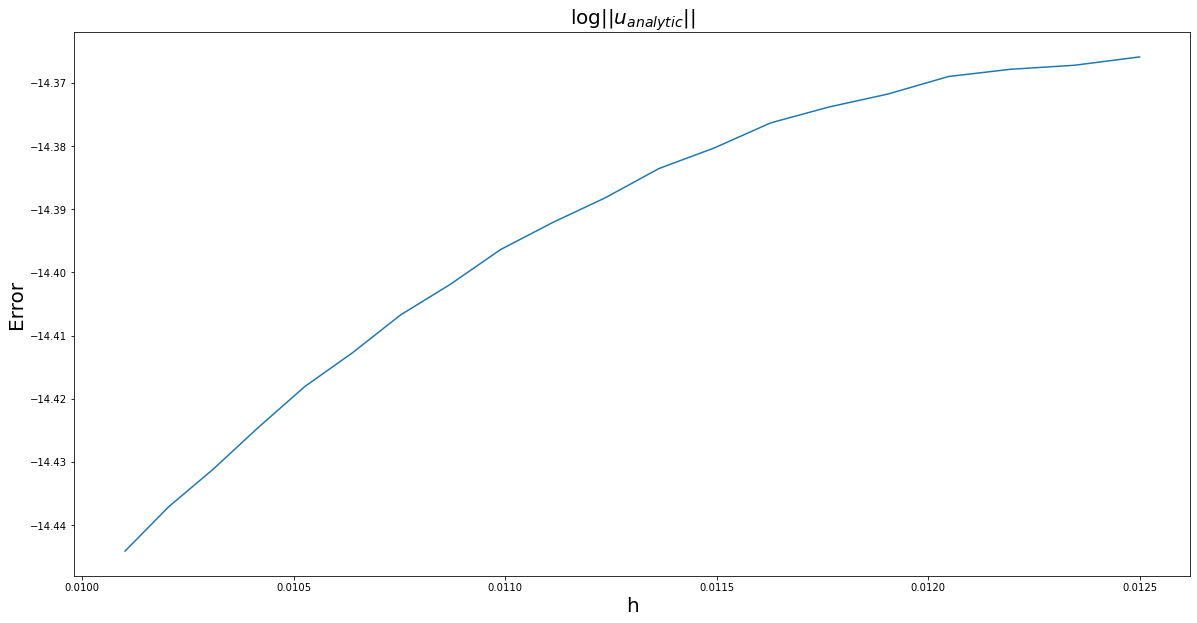

In [64]:
fig = plt.figure(figsize=(20, 10))
plt.plot(h, [math.log(i+1e-40) for i in e])
plt.xlabel('h', fontsize = 20)
plt.ylabel('Error', fontsize = 20)
plt.title(r'$\log||u_{analytic}||$', fontsize = 20)
plt.show()

# plotly
# fig_error = go.Figure()
# fig_error.add_trace(go.Scatter(x = h, y = [math.log(i + 1e-40) for i in e]))
# fig_error.update_layout(title = 'Error with different length of step',
#                        xaxis_title = r'$h$',
#                        yaxis_title = '$\log||u_{analytic}||$',
#                        template = 'plotly_dark')
# fig_error.show()

* Обратно пропорциональная зависимость у длины шага по пространственным компонентам и ошибкой метода

In [65]:
eps = np.linspace(1e-5, 0.01, 10)
mses = []
maes = []
errors = []
for i in tqdm(range(len(eps))):
    u_tmp, x_tmp, y_tmp, tmp = liebman(varepsilon=eps[i])
    errors.append(norm_error(x_tmp, y_tmp, u_tmp))
    mses.append(MSE(x,y,u_tmp))
    maes.append(MAE(x,y,u_tmp))

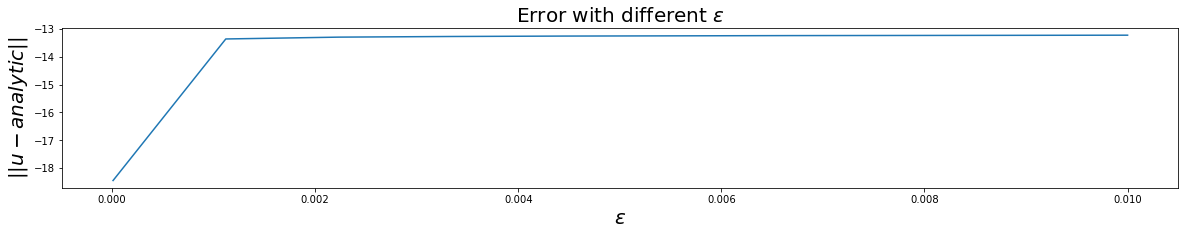

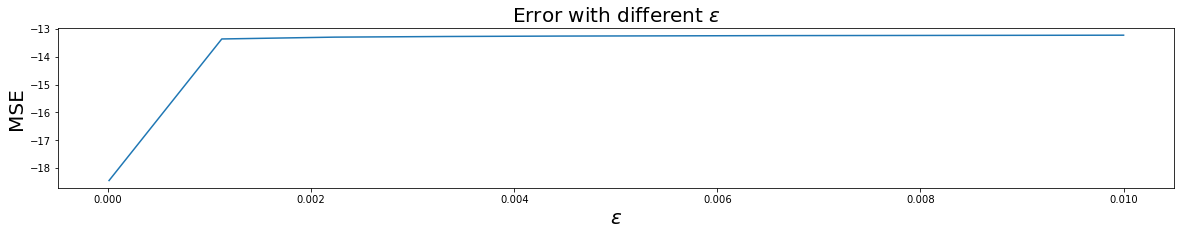

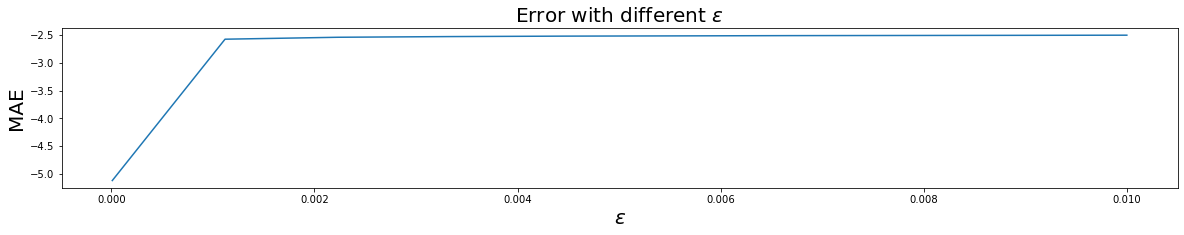

In [72]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(3,1,1)
plt.plot(eps, [math.log(i+1e-40) for i in errors])
plt.xlabel(r'$\varepsilon$', fontsize = 20)
plt.ylabel(r'$||u - analytic||$', fontsize = 20)
plt.title('Error with different ' + r'$\varepsilon$', fontsize = 20)
plt.show()

fig = plt.figure(figsize=(20, 10))
plt.subplot(3,1,2)
plt.plot(eps, [math.log(i+1e-40) for i in mses])
plt.xlabel(r'$\varepsilon$', fontsize = 20)
plt.ylabel('MSE', fontsize = 20)
plt.title('Error with different ' + r'$\varepsilon$', fontsize = 20)
plt.show()

fig = plt.figure(figsize=(20, 10))
plt.subplot(3,1,3)
plt.plot(eps, [math.log(i+1e-40) for i in maes])
plt.xlabel(r'$\varepsilon$', fontsize = 20)
plt.ylabel('MAE', fontsize = 20)
plt.title('Error with different ' + r'$\varepsilon$', fontsize = 20)
plt.show()
# fig_norm = go.Figure()
# fig_norm.add_trace(go.Scatter(x = eps, y = [math.log(i+1e-40) for i in errors]))
# fig_norm.update_layout(title = r'$\text{Error with different }\varepsilon$',
#                       xaxis_title = r'$\varepsilon$',
#                       yaxis_title = r'$||u - analytic||$',
#                       template = 'plotly_dark')
# fig_mse = go.Figure()
# fig_mse.add_trace(go.Scatter(x = eps, y = [math.log(i+1e-40) for i in mses]))
# fig_mse.update_layout(title = r'$\text{Error with different }\varepsilon$',
#                       xaxis_title = r'$\varepsilon$',
#                       yaxis_title = r'$||u - analytic||_2$',
#                       template = 'plotly_dark')
# fig_mae = go.Figure()
# fig_mae.add_trace(go.Scatter(x = eps, y = [math.log(i + 1e-40) for i in maes]))
# fig_mae.update_layout(title = r'$\text{Error with different }\varepsilon$',
#                       xaxis_title = r'$\varepsilon$',
#                       yaxis_title = r'$MAE$',
#                       template = 'plotly_dark')
# fig_norm.show()
# fig_mse.show()
# fig_mae.show()

* С увеличением точности ошибка нелинейно, но увеличивается 

<a name = 'step5'></a>

## Метод верхних релаксаций

[К оглавлению](#content)

<a name = 'step5.1'></a>

### Теория

Другим методом решения большого числа СЛАУ является метод верхних релаксаций. 
Для нулевой итерации применим интерполяцию. Опишем метод для $i$-го шага.

$$u_{i,j}^{(k+1)} = (1-\omega)\cdot u_{i,j}^{(k)} +  \frac{\omega}{2\left(1 + \frac{h_x^2}{h_y^2} - h_x^2\right)}\cdot \left(u_{i+1,j}^{(k)} + u_{i-1,j}^{(k)}\right) + \frac{1}{h_y^2} \left(u_{i,j+1}^{(k)} + u_{i,j-1}^{(k)}\right)$$

Критерий остановки:
$$||u^{(k+1)} - u^{(k)}|| \leq \varepsilon \hspace{0.5cm} ||u^{(k)}|| = \underset{i,j}{\max}\left| u_{i,j}^{(k)} \right|$$

Существенный недостаток -- зависимость времени работы от количества пространственных разбиений. Следует это из увеличения количества уравнений в системе. 

<a name = 'step5.2'></a>
### Реализация

In [73]:
def relaxation(
    xr = math.pi/2,yr = math.pi/2,
    len_x = 75, len_y = 75, varepsilon = 1e-5, w = 1.5):
    hx = xr/len_x
    hy = yr/len_y
    x = np.arange(0,xr + hx/2, hx)
    y = np.arange(0,yr + hy/2, hy)
    X = [x for _ in range(len(x))]
    Y = [[y[i] for _ in x] for i in range(len(y))]
    
    prev_t = np.zeros([len(x),len(y)])
    cur_t = np.zeros([len(x),len(y)])
	  #интерполяция
    for j in range(0,len(y)):
        coeff = (f_2(None, y[j]) - f_1(None, y[j]))/(len(y)-1)
        addition = f_1(None, y[j])
        for i in range(len(x)):
            cur_t[i][j] = coeff*i + addition

    #w = 0.5
    count = 0
    while(True):
        count += 1
        prev_t = copy.deepcopy(cur_t)
        for i in range(1,len(x)-1):
            cur_t[i][0] = f_3(x[i])
            for j in range(1,len(y)-1):
                coeff_left = 2*(1/(hx**2) + 1/(hy**2) - 1)
                coeff_right_fst = 1/(hx**2)
                coeff_right_scd = 1/(hy**2)
                M = coeff_right_fst*(prev_t[i+1][j] + cur_t[i-1][j]) + coeff_right_scd*(prev_t[i][j+1] + cur_t[i][j-1])
                M /= coeff_left  
                cur_t[i][j] = (1 - w) * prev_t[i][j] + w * M 
            cur_t[i][-1] = f_4(x[i])
        norm_ = norm(cur_t, prev_t,len(x),len(y))
        # print(norm)
        if(norm_ <= varepsilon or count > 10000):
            break
    return cur_t, X, Y, count

<a name = 'step5.3'></a>
### Исследования

In [74]:
start = time.time()
u_relax, X_tmp, Y_tmp, count_relaxation = relaxation()
time_relaxation = time.time() - start

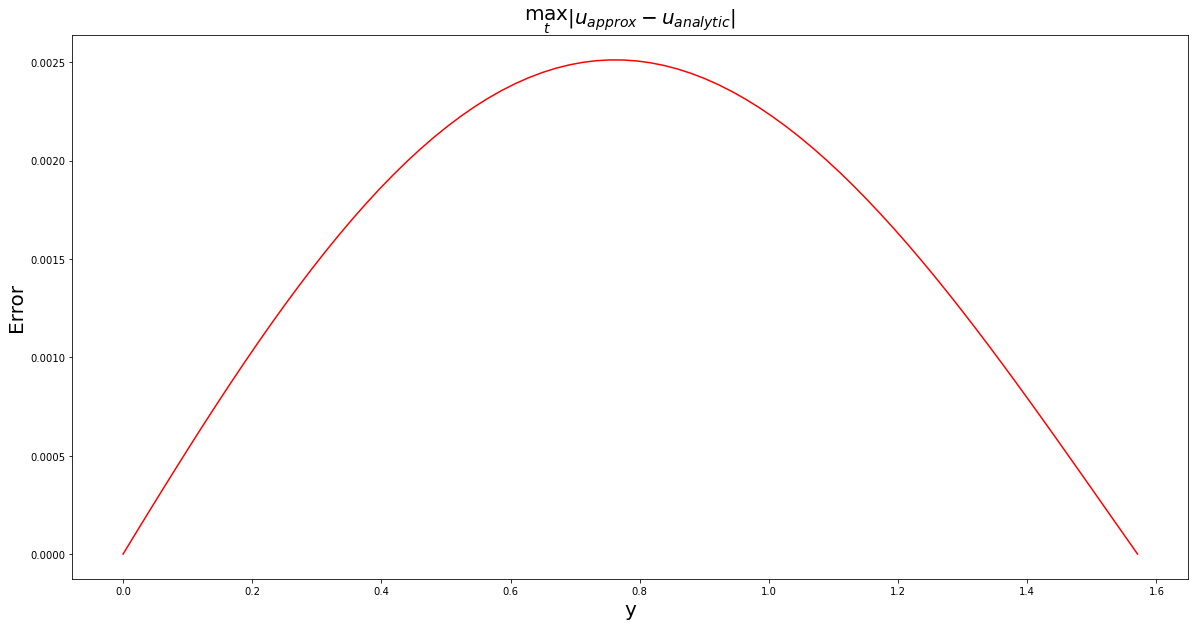

In [75]:
er = normm(x,y,u_relax)
fig = plt.figure(figsize=(20, 10))
plt.plot(x, er, color = 'red')
plt.xlabel('y', fontsize = 20)
plt.ylabel('Error', fontsize = 20)
plt.title(r'$\max_{t} \left|u_{approx} - u_{analytic}\right|$', fontsize = 20)
plt.show()
#save_plot(fig_check_tmp)

In [19]:
construct_3d_plot(relaxation, 'relaxation ')

Total error =  2.655777842390291e-10


In [76]:
h,e = error_data(relaxation)

h = [xr/i for i in h]

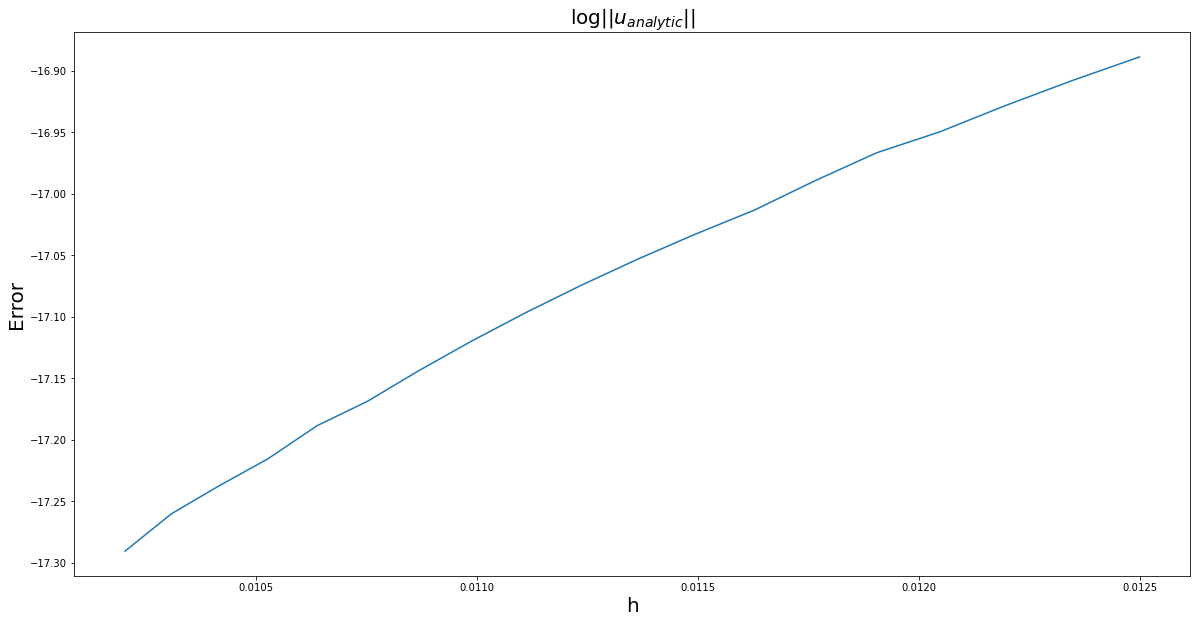

In [80]:
fig = plt.figure(figsize=(20, 10))
plt.plot(h[:-1], [math.log(i+1e-40) for i in e[-1:0:-1]])
plt.xlabel('h', fontsize = 20)
plt.ylabel('Error', fontsize = 20)
plt.title(r'$\log||u_{analytic}||$', fontsize = 20)
plt.show()

# fig_error = go.Figure()
# fig_error.add_trace(go.Scatter(x = h, y = [math.log(i+1e-40) for i in e[-1:0:-1]]))
# fig_error.update_layout(title = 'Error with different length of step',
#                        xaxis_title = r'$h$',
#                        yaxis_title = '||u-analytic||',
#                        template = 'plotly_dark')
# fig_error.show()

* Ошибка растет при уменьшении количества разбиений

In [81]:
eps = np.linspace(0.00001, 0.01, 20)
mses = []
maes = []
errors = []
for i in tqdm(range(len(eps))):
    u_tmp, x_tmp, y_tmp, tmp = relaxation(varepsilon=eps[i])
    errors.append(norm_error(x_tmp, y_tmp, u_tmp))
    mses.append(MSE(x,y,u_tmp))
    maes.append(MAE(x,y,u_tmp))

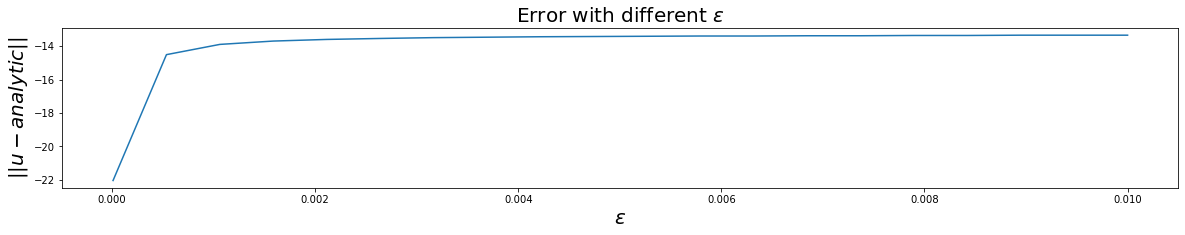

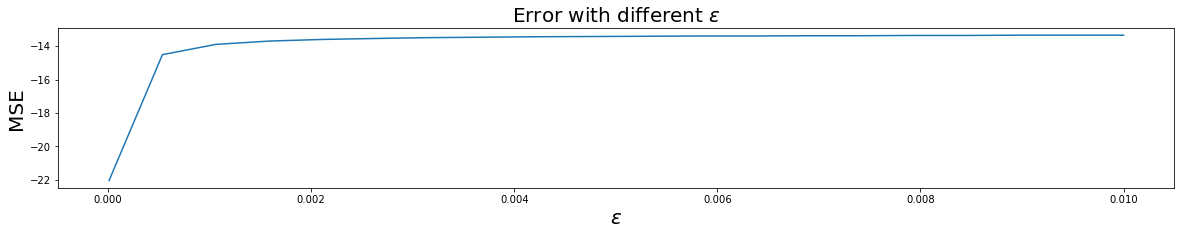

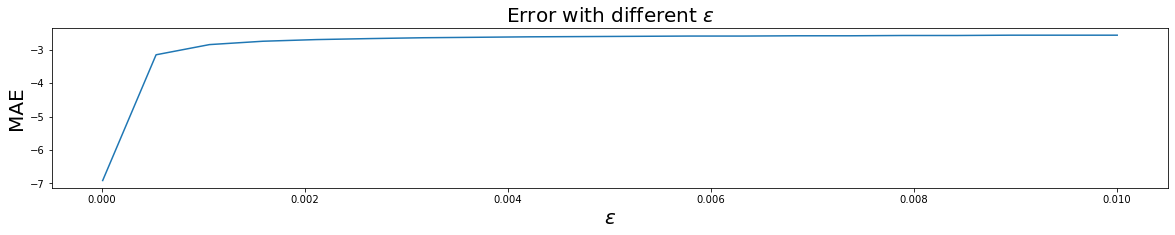

In [82]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(3,1,1)
plt.plot(eps, [math.log(i+1e-40) for i in errors])
plt.xlabel(r'$\varepsilon$', fontsize = 20)
plt.ylabel(r'$||u - analytic||$', fontsize = 20)
plt.title('Error with different ' + r'$\varepsilon$', fontsize = 20)
plt.show()

fig = plt.figure(figsize=(20, 10))
plt.subplot(3,1,2)
plt.plot(eps, [math.log(i+1e-40) for i in mses])
plt.xlabel(r'$\varepsilon$', fontsize = 20)
plt.ylabel('MSE', fontsize = 20)
plt.title('Error with different ' + r'$\varepsilon$', fontsize = 20)
plt.show()

fig = plt.figure(figsize=(20, 10))
plt.subplot(3,1,3)
plt.plot(eps, [math.log(i+1e-40) for i in maes])
plt.xlabel(r'$\varepsilon$', fontsize = 20)
plt.ylabel('MAE', fontsize = 20)
plt.title('Error with different ' + r'$\varepsilon$', fontsize = 20)
plt.show()

# fig_norm = go.Figure()
# fig_norm.add_trace(go.Scatter(x = eps, y = [math.log(i+1e-40) for i in errors]))
# fig_norm.update_layout(title = r'$\text{Error with different }\varepsilon$',
#                       xaxis_title = r'$\varepsilon$',
#                       yaxis_title = r'$||u - analytic||$',
#                       template = 'plotly_dark')
# fig_mse = go.Figure()
# fig_mse.add_trace(go.Scatter(x = eps, y = [math.log(i+1e-40) for i in mses]))
# fig_mse.update_layout(title = r'$\text{Error with different }\varepsilon$',
#                       xaxis_title = r'$\varepsilon$',
#                       yaxis_title = r'$||u - analytic||_2$',
#                       template = 'plotly_dark')
# fig_mae = go.Figure()
# fig_mae.add_trace(go.Scatter(x = eps, y = [math.log(i + 1e-40) for i in maes]))
# fig_mae.update_layout(title = r'$\text{Error with different }\varepsilon$',
#                       xaxis_title = r'$\varepsilon$',
#                       yaxis_title = r'$MAE$',
#                       template = 'plotly_dark')
# fig_norm.show()
# fig_mse.show()
# fig_mae.show()

* Поварьируем параметр релаксации от 1 до 2

In [38]:
times = []
counts = []
errors = []
omega = np.linspace(1.15,1.95,4)
for i in tqdm(range(len(omega))):
  start = time.time()
  u_relax, X_tmp, Y_tmp, count_relaxation = relaxation(w = omega[i])
  errors.append(max(normm(x,y,u_relax)))
  times.append(time.time() - start)
  counts.append(count_relaxation)

In [39]:
from prettytable import PrettyTable

th = ['Omega']
for o in omega:
  th.append(o)
table = PrettyTable(th)
td1 = ['Times']
for t in times:
  td1.append(t)

td2 = ['Iterations']
for c in counts:
  td2.append(c)

td3 = ['Errors']
for e in errors:
  td3.append(e)

table.add_row(td1)
table.add_row(td2)
table.add_row(td3)
print(table)

+------------+----------------------+-----------------------+-----------------------+------------------------+
|   Omega    |         1.15         |   1.4166666666666665  |   1.6833333333333331  |          1.95          |
+------------+----------------------+-----------------------+-----------------------+------------------------+
|   Times    |  55.76206088066101   |   36.63481783866882   |   19.429002046585083  |   4.568631410598755    |
| Iterations |         1936         |          1256         |          677          |          160           |
|   Errors   | 0.005594672210953777 | 0.0031024405484594286 | 0.0014001007568864576 | 4.5564757858773675e-05 |
+------------+----------------------+-----------------------+-----------------------+------------------------+


Посмотрим в диапазоне [1.95,2]

In [33]:
times = []
counts = []
errors = []
omega = np.linspace(1.96,2,4)
for i in tqdm(range(len(omega))):
  start = time.time()
  u_relax, X_tmp, Y_tmp, count_relaxation = relaxation(w = omega[i])
  errors.append(max(normm(x,y,u_relax)))
  times.append(time.time() - start)
  counts.append(count_relaxation)

In [34]:
th = ['Omega']
for o in omega:
  th.append(o)
table = PrettyTable(th)
td1 = ['Times']
for t in times:
  td1.append(t)

td2 = ['Iterations']
for c in counts:
  td2.append(c)

td3 = ['Errors']
for e in errors:
  td3.append(e)

table.add_row(td1)
table.add_row(td2)
table.add_row(td3)
print(table)

+------------+-----------------------+-----------------------+------------------------+---------------------+
|   Omega    |          1.96         |   1.9733333333333334  |   1.9866666666666666   |         2.0         |
+------------+-----------------------+-----------------------+------------------------+---------------------+
|   Times    |   6.067176342010498   |    9.29747748374939   |   22.464454650878906   |  308.07794189453125 |
| Iterations |          213          |          326          |          674           |        10001        |
|   Errors   | 2.074779761185308e-05 | 3.308006560609478e-05 | 2.9664556987718527e-05 | 0.16598847069119982 |
+------------+-----------------------+-----------------------+------------------------+---------------------+


* При $\omega = 1.95$ достигается самое быстрое, точное решение при минимальном количестве итераций.

<a name = 'step6'></a>
## Метод Зейделя

[К оглавлению](#content)

<a name = 'step6.1'></a>
### Теория

Метод верхних релаксаций с параметром $\omega = 1$

<a name = 'step6.2'></a>
### Реализация

In [83]:
def zeidel(xr = math.pi/2, yr = math.pi/2,len_x = 75, len_y = 75, varepsilon = 1e-5):
    hx = xr/len_x
    hy = yr/len_y
    x = np.arange(0,xr + hx/2, hx)
    y = np.arange(0,yr + hy/2, hy)
    X = [x for _ in range(len(x))]
    Y = [[y[i] for _ in x] for i in range(len(y))]
    
    prev_t = np.zeros([len(x),len(y)])
    cur_t = np.zeros([len(x),len(y)])
	  #интерполяция
    for j in range(0,len(y)):
        coeff = (f_2(None, y[j]) - f_1(None, y[j]))/(len(y)-1)
        addition = f_1(None, y[j])
        for i in range(len(x)):
            cur_t[i][j] = coeff*i + addition

    #w = 0.5
    count = 0
    while(True):
        count += 1
        prev_t = copy.deepcopy(cur_t)
        for i in range(1,len(x)-1):
            cur_t[i][0] = f_3(x[i])
            for j in range(1,len(y)-1):
                coeff_left = 2*(1/(hx**2) + 1/(hy**2) - 1)
                coeff_right_fst = 1/(hx**2)
                coeff_right_scd = 1/(hy**2)
                M = coeff_right_fst*(prev_t[i+1][j] + cur_t[i-1][j]) + coeff_right_scd*(prev_t[i][j+1] + cur_t[i][j-1])
                M /= coeff_left  
                cur_t[i][j] = M 
            cur_t[i][-1] = f_4(x[i])
        norm_ = norm(cur_t, prev_t,len(x),len(y))
        # print(norm)
        if(norm_ <= varepsilon):
            break
    return cur_t, X, Y, count

<a name = 'step6.3'></a>
### Исследования

In [84]:
start = time.time()
u_zeidel, X_tmp, Y_tmp, count_zeidel = zeidel()
time_zeidel = time.time() - start

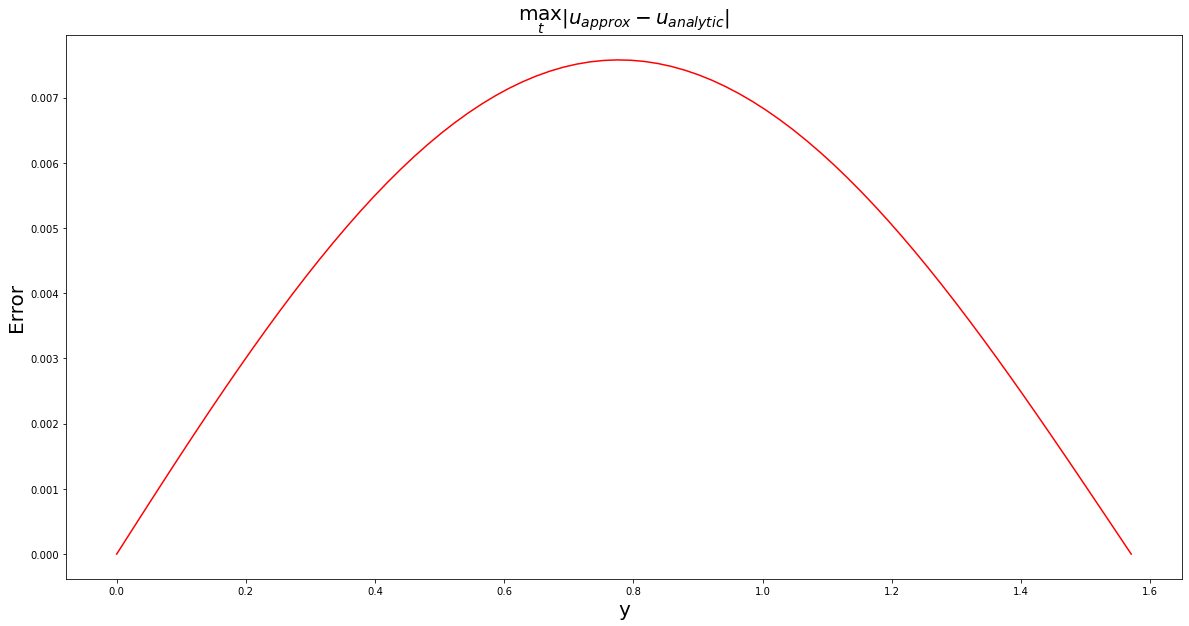

In [85]:
er = normm(x,y,u_zeidel)
fig = plt.figure(figsize=(20, 10))
plt.plot(x, er, color = 'red')
plt.xlabel('y', fontsize = 20)
plt.ylabel('Error', fontsize = 20)
plt.title(r'$\max_{t} \left|u_{approx} - u_{analytic}\right|$', fontsize = 20)
plt.show()
#save_plot(fig_check_tmp)
# er = normm(x,y,u_zeidel)
# fig_check_tmp = go.Figure()
# fig_check_tmp.add_trace(go.Scatter(x = y, y = er))
# fig_check_tmp.update_layout(title = "Error (fix x)",
#                             xaxis_title = r"$y$",
#                             yaxis_title = r'$\max |u - analytic|$', 
#                             template='plotly_dark')
# fig_check_tmp.show()
# fig_check_tmp = go.Figure()
# fig_check_tmp.add_trace(go.Scatter(x = x, y = er))
# fig_check_tmp.update_layout(title = "Error (fix y)",
#                             xaxis_title = r"$x$",
#                             yaxis_title = r'$\max |u - analytic|$', 
#                             template='plotly_dark')
# fig_check_tmp.show()
# #save_plot(fig_check_tmp)

In [44]:
construct_3d_plot(zeidel, 'Zeidel ')

Total error =  2.4188988460393327e-09


In [86]:
h,e = error_data(zeidel)

h = [xr / i for i in h]

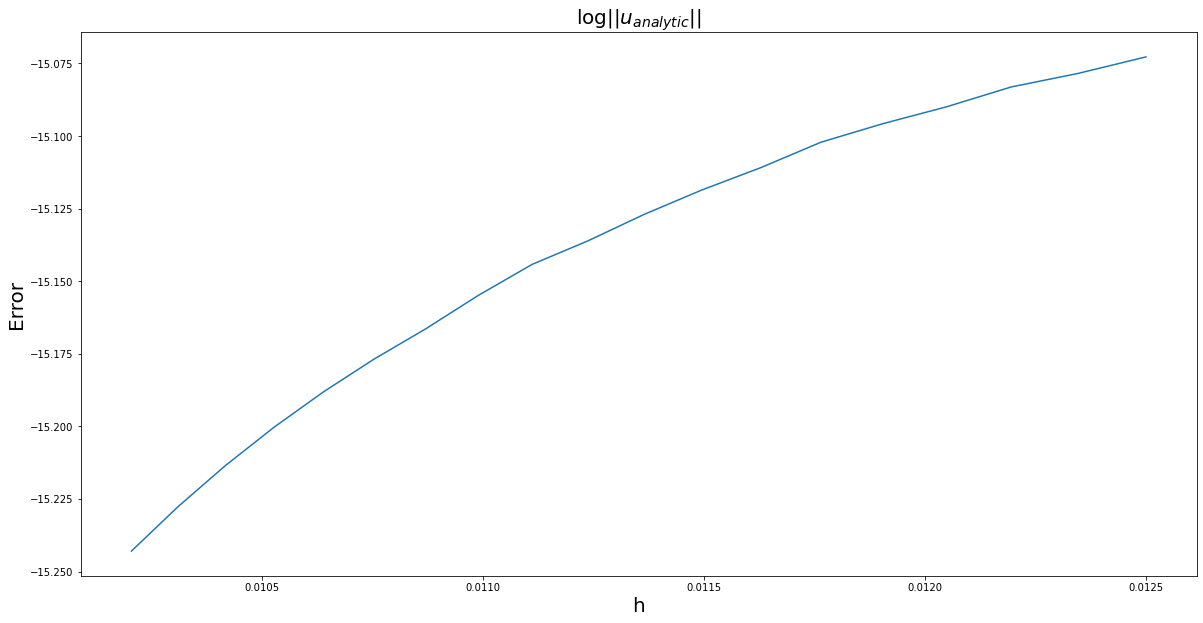

In [87]:
fig = plt.figure(figsize=(20, 10))
plt.plot(h[:-1], [math.log(i+1e-40) for i in e[-1:0:-1]])
plt.xlabel('h', fontsize = 20)
plt.ylabel('Error', fontsize = 20)
plt.title(r'$\log||u_{analytic}||$', fontsize = 20)
plt.show()

# fig_error = go.Figure()
# fig_error.add_trace(go.Scatter(x = h, y = [math.log(i+1e-40) for i in e[-1:0:-1]]))
# fig_error.update_layout(title = 'Error with different length of step',
#                        xaxis_title = r'$h$',
#                        yaxis_title = '||u-analytic||',
#                        template='plotly_dark')
# fig_error.show()

* Не смотря на существенное увеличение времени работы программы из-за уменьшения шага по пространству, ошибка так же снижается

In [51]:
eps = np.linspace(0.0001, 0.1, 15)
mses = []
maes = []
errors = []
for i in tqdm(range(len(eps))):
    u_tmp, x_tmp, y_tmp, tmp = zeidel(varepsilon=eps[i])
    errors.append(norm_error(x_tmp, y_tmp, u_tmp))
    mses.append(MSE(x,y,u_tmp))
    maes.append(MAE(x,y,u_tmp))

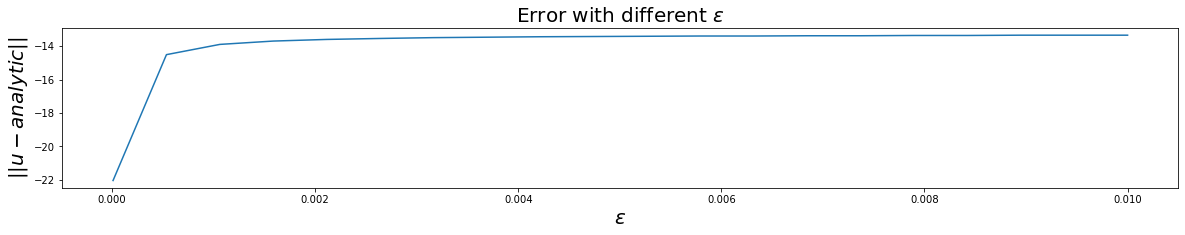

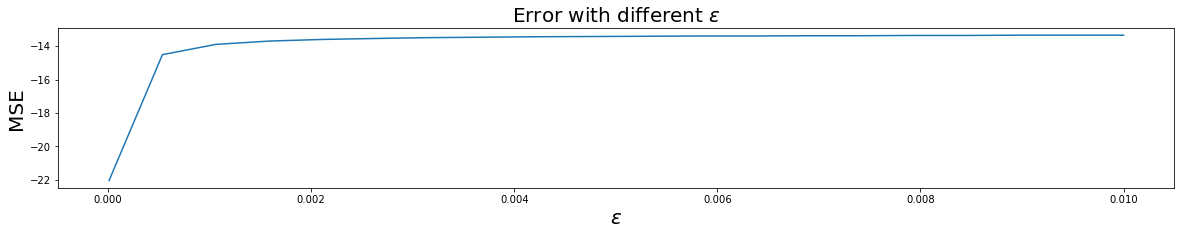

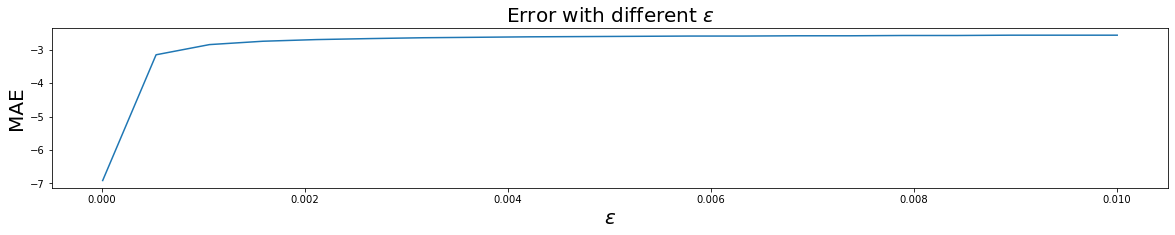

In [88]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(3,1,1)
plt.plot(eps, [math.log(i+1e-40) for i in errors])
plt.xlabel(r'$\varepsilon$', fontsize = 20)
plt.ylabel(r'$||u - analytic||$', fontsize = 20)
plt.title('Error with different ' + r'$\varepsilon$', fontsize = 20)
plt.show()

fig = plt.figure(figsize=(20, 10))
plt.subplot(3,1,2)
plt.plot(eps, [math.log(i+1e-40) for i in mses])
plt.xlabel(r'$\varepsilon$', fontsize = 20)
plt.ylabel('MSE', fontsize = 20)
plt.title('Error with different ' + r'$\varepsilon$', fontsize = 20)
plt.show()

fig = plt.figure(figsize=(20, 10))
plt.subplot(3,1,3)
plt.plot(eps, [math.log(i+1e-40) for i in maes])
plt.xlabel(r'$\varepsilon$', fontsize = 20)
plt.ylabel('MAE', fontsize = 20)
plt.title('Error with different ' + r'$\varepsilon$', fontsize = 20)
plt.show()



# fig_norm = go.Figure()
# fig_norm.add_trace(go.Scatter(x = eps, y = errors))
# fig_norm.update_layout(title = r'$\text{Error with different }\varepsilon$',
#                       xaxis_title = r'$\varepsilon$',
#                       yaxis_title = r'$||u - analytic||$',
#                        template = 'plotly_dark')
# fig_mse = go.Figure()
# fig_mse.add_trace(go.Scatter(x = eps, y = mses))
# fig_mse.update_layout(title = r'$\text{Error with different }\varepsilon$',
#                       xaxis_title = r'$\varepsilon$',
#                       yaxis_title = r'$||u - analytic||_2$',
#                       template = 'plotly_dark')
# fig_mae = go.Figure()
# fig_mae.add_trace(go.Scatter(x = eps[1:], y = maes[1:]))
# fig_mae.update_layout(title = r'$\text{Error with different }\varepsilon$',
#                       xaxis_title = r'$\varepsilon$',
#                       yaxis_title = r'$MAE$',
#                       template = 'plotly_dark')
# fig_norm.show()
# fig_mse.show()
# fig_mae.show()

* Похожие на метод релаксации тренды

In [49]:
th = ['Method', 'Liebmann', 'Relaxation', 'Zeidel']
td = ['Time', time_liebman, time_relaxation, time_zeidel]
td1 = ['Iterations', count_liebman, count_relaxation, count_zeidel]
table = PrettyTable(th)
table.add_row(td)
table.add_row(td1)
print(table)

+------------+-------------------+------------------+-------------------+
|   Method   |      Liebmann     |    Relaxation    |       Zeidel      |
+------------+-------------------+------------------+-------------------+
|    Time    | 96.37380743026733 | 29.5268714427948 | 56.48193001747131 |
| Iterations |        3758       |       160        |        2394       |
+------------+-------------------+------------------+-------------------+
